In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import sklearn

torch.Size([60000, 28, 28])
torch.Size([60000])


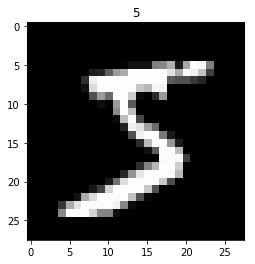

In [51]:
torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = True   # set to False if you have downloaded


# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1), volatile=True).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]
#test_y = Variable(test_y)

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.PReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.PReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [13]:
def train():
    
    cnn = CNN()
    print(cnn)  # net architecture

    optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
    loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

    # following function (plot_with_labels) is for visualization, can be ignored if not interested

    # training and testing
    for epoch in range(EPOCH):
        for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
            b_x = Variable(x)   # batch x
            b_y = Variable(y)   # batch y

            output = cnn(b_x)[0]               # cnn output
            loss = loss_func(output, b_y)   # cross entropy loss
            optimizer.zero_grad()           # clear gradients for this training step
            loss.backward()                 # backpropagation, compute gradients
            optimizer.step()                # apply gradients

            if step % 50 == 0:
                test_output, last_layer = cnn(test_x)
                pred_y = torch.max(test_output, 1)[1].data.squeeze()
                accuracy = sum(pred_y == test_y) / float(test_y.size(0))
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0], '| test accuracy: %.2f' % accuracy)


    # print 10 predictions from test data
    test_output, _ = cnn(test_x[:10])
    pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
    print(pred_y, 'prediction number')
    print(test_y[:10].numpy(), 'real number')

In [7]:
train()

CNN (
  (conv1): Sequential (
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU (1)
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU (1)
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (out): Linear (1568 -> 10)
)
Epoch:  0 | train loss: 2.3001 | test accuracy: 0.12
Epoch:  0 | train loss: 0.4401 | test accuracy: 0.82
Epoch:  0 | train loss: 0.3700 | test accuracy: 0.89
Epoch:  0 | train loss: 0.2937 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1163 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0666 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2306 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0614 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2692 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1826 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0961 | test accuracy: 0.96
Epoch: 

In [8]:
#save model params
torch.save(cnn.state_dict(), 'params.pkl')

In [14]:
#load model
model = CNN()
model.load_state_dict(torch.load('params.pkl'))


test_output, _ = model(test_x[:2000])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:20].numpy(), 'real number')

[7 2 1 ..., 3 9 5] prediction number
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4] real number


In [55]:
#precision recall fscore support
from sklearn.metrics import precision_recall_fscore_support as score

predicted = list(pred_y)
y_test = list(test_y)

precision, recall, fscore, support = score(y_test, predicted)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [ 0.99  1.    0.96  0.98  0.98  0.97  0.96  1.    0.98  0.97]
recall: [ 0.99  0.99  1.    1.    0.96  0.98  0.99  0.96  0.97  0.96]
fscore: [ 0.99  0.99  0.98  0.99  0.97  0.97  0.98  0.98  0.98  0.97]
support: [175 234 219 207 217 179 178 205 192 194]


Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[173   0   0   0   0   0   2   0   0   0]
 [  0 232   0   0   0   0   1   0   1   0]
 [  0   0 219   0   0   0   0   0   0   0]
 [  0   0   0 206   0   1   0   0   0   0]
 [  0   1   0   0 209   0   4   0   0   3]
 [  0   0   1   2   0 175   0   0   1   0]
 [  0   0   0   0   0   2 176   0   0   0]
 [  0   0   5   2   0   0   0 196   0   2]
 [  1   0   2   0   1   0   0   0 187   1]
 [  0   0   0   0   3   2   0   0   2 187]]
Normalized confusion matrix
[[ 0.99  0.    0.    0.    0.    0.    0.01  0.    0.    0.  ]
 [ 0.    0.99  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.96  0.    0.02  0.    0.    0.01]
 [ 0.    0.    0.01  0.01  0.    0.98  0.    0.    0.01  0.  ]
 [ 0.    0.    0.    0.    0.    0.01  0.99  0.    0.    0

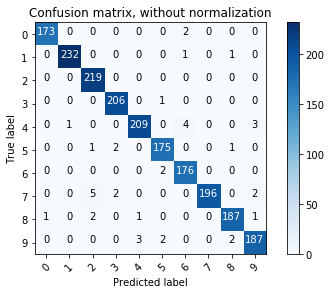

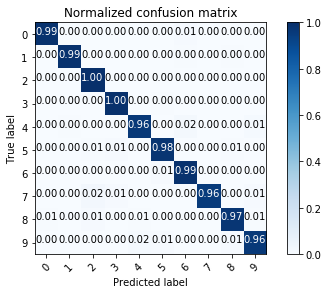

In [53]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = [0,1,2,3,4,5,6,7,8,9]

model = CNN()
model.load_state_dict(torch.load('params.pkl'))
test_output, _ = model(test_x[:2000])
y_pred = torch.max(test_output, 1)[1].data.numpy().squeeze()
test_y = test_y.numpy()
# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()